***Bollinger Bands and RSI Trading Strategy***

*   The Trading signal is based on simple Bollinger Bands and RSI
    *   RSI = 100 - (100/1+RS) and RS = Avg Gain/Avg Loss

    *   Upper_Band = MA(TP, n) + m * σ[TP, n]
    *   Lower_Band = MA(TP, n) - m * σ[TP, n]

*   The trading signal is backtested on 10 of the S&P 500 Stocks

*  This report would use Adj close to calculate every formula 

*   When one of the conditions below is met, it will execute corrsponding trades.

  1.   Buy when the close price goes below the Lower Band and the RSI is less than 30 
  2.   Sell when the close price goes above the Upper Band and the RSI is greater than 70


*   The performance of the strategy performance is evaluated by

    1.   Culmutative returns
    2.   Sharpe ratio




*  Below are several ways to enhance the accuracy and performance of the strategy:

  1. Incorporate transaction costs into the calculation of the return 
  2. Conduct simulations using various combinations of periods for both the RSI and Bollinger Band.















In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
pd.options.mode.chained_assignment = None  # default='warn'

In [4]:
# fetch S&P500 constituents using requests
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500_table = pd.read_html(url)[0]
# define time period
start_date = "2020-01-01"
end_date = "2022-12-31"
periods = [7,14]

In [5]:
# Only include those that added before the Date added
sp500_table = sp500_table[sp500_table['Date added'] <= start_date]

In [36]:
sp500_filter_tickers = sp500_table['Symbol'].to_list()[:10]

In [37]:
# Download data from yfinance
df = yf.download(sp500_filter_tickers, start=start_date, end=end_date, interval = "1d")
# Get the Adjust close data frame
sp500Dfs = ([pd.DataFrame( {'Adj Close':df['Adj Close'][i].dropna()}) for i in sp500_filter_tickers])


[*********************100%***********************]  10 of 10 completed


In [38]:
# Define a function to create and get the bollinger Bands 
def bollinger_bands(data, window_size):
  rolling_mean = data['Adj Close'].rolling(window=window_size).mean() #Simple Moving Average(SMA)
  rolling_std = data['Adj Close'].rolling(window=window_size).std()
  data['UpperBand'] = rolling_mean + (2 * rolling_std)
  data['LowerBand'] = rolling_mean - (2 * rolling_std)
  return data
# Define a function to create and get the Relative Strength Index(RSI)
def RSI(data, periods):
  delta = data['Adj Close'].diff()
  up = delta.clip(lower=0)
  down = -1 * delta.clip(upper=0)
  ma_up = up.rolling(window = periods).mean()
  ma_down = down.rolling(window = periods).mean()
  rsi = ma_up / ma_down
  rsi = 100 - (100/(1 + rsi))
  data['RSI'] = rsi
  data['Overbought'] = 70
  data['Oversold'] = 30
  return data

# Define a function to create and get the trading strategy
# Buy when the close price goes below the Lower Band and the RSI is less than 30
# Sell when the close price goes above the Upper Band and the RSI is greater than 70

def strategy(data):
  position = 0
  buy_price = []
  sell_price = []
  for i in range(len(data)):
    if data['Adj Close'][i] < data['LowerBand'][i] and data["RSI"][i] < data['Oversold'][i] and position == 0:
      position = 1
      data["Position"][i] = position
      buy_price.append(data['Adj Close'][i])
      sell_price.append(np.nan)
    elif data['Adj Close'][i] > data['UpperBand'][i] and data['RSI'][i] > data['Overbought'][i] and position == 1:
      position = 0
      data["Position"][i] = position
      sell_price.append(data['Adj Close'][i])
      buy_price.append(np.nan)
    else:
      data["Position"][i] = position
      sell_price.append(np.nan)
      buy_price.append(np.nan)
  return (buy_price, sell_price, data)


In [39]:
updated_sp500Dfs = {}

for period in periods:
  temData = []
  for sp500Df in sp500Dfs:
    # Add the Bollinger Bands to the data set
    data = None
    data = bollinger_bands(sp500Df, period)
    # Add the RSI to the data set
    data =RSI(data, period)
    data['Position']= np.nan
    # Implement the trading strategy
    buy_price, sell_price, data = strategy(data)
    data['Buy'] = buy_price
    data['Sell'] = sell_price

    # Calculate Simple return , log return and strategy return
    data['Simple_Returns'] = data.pct_change(1)['Adj Close']
    data['Log_Returns'] = np.log(1+data['Simple_Returns'])
    data['Strategy_Log_Returns'] = data['Position'].shift(1)* data['Log_Returns']
    data['Strategy_Simple_Returns'] = data['Position'].shift(1)* data['Simple_Returns']
    data["Culmutative_Simple_Return"] = (1+data["Strategy_Simple_Returns"]).cumprod() - 1
    data["Culmutative_Log_Return"] = (1+data["Strategy_Log_Returns"]).cumprod() - 1
    temData.append(data.copy())
  updated_sp500Dfs[str(period)] = (temData)



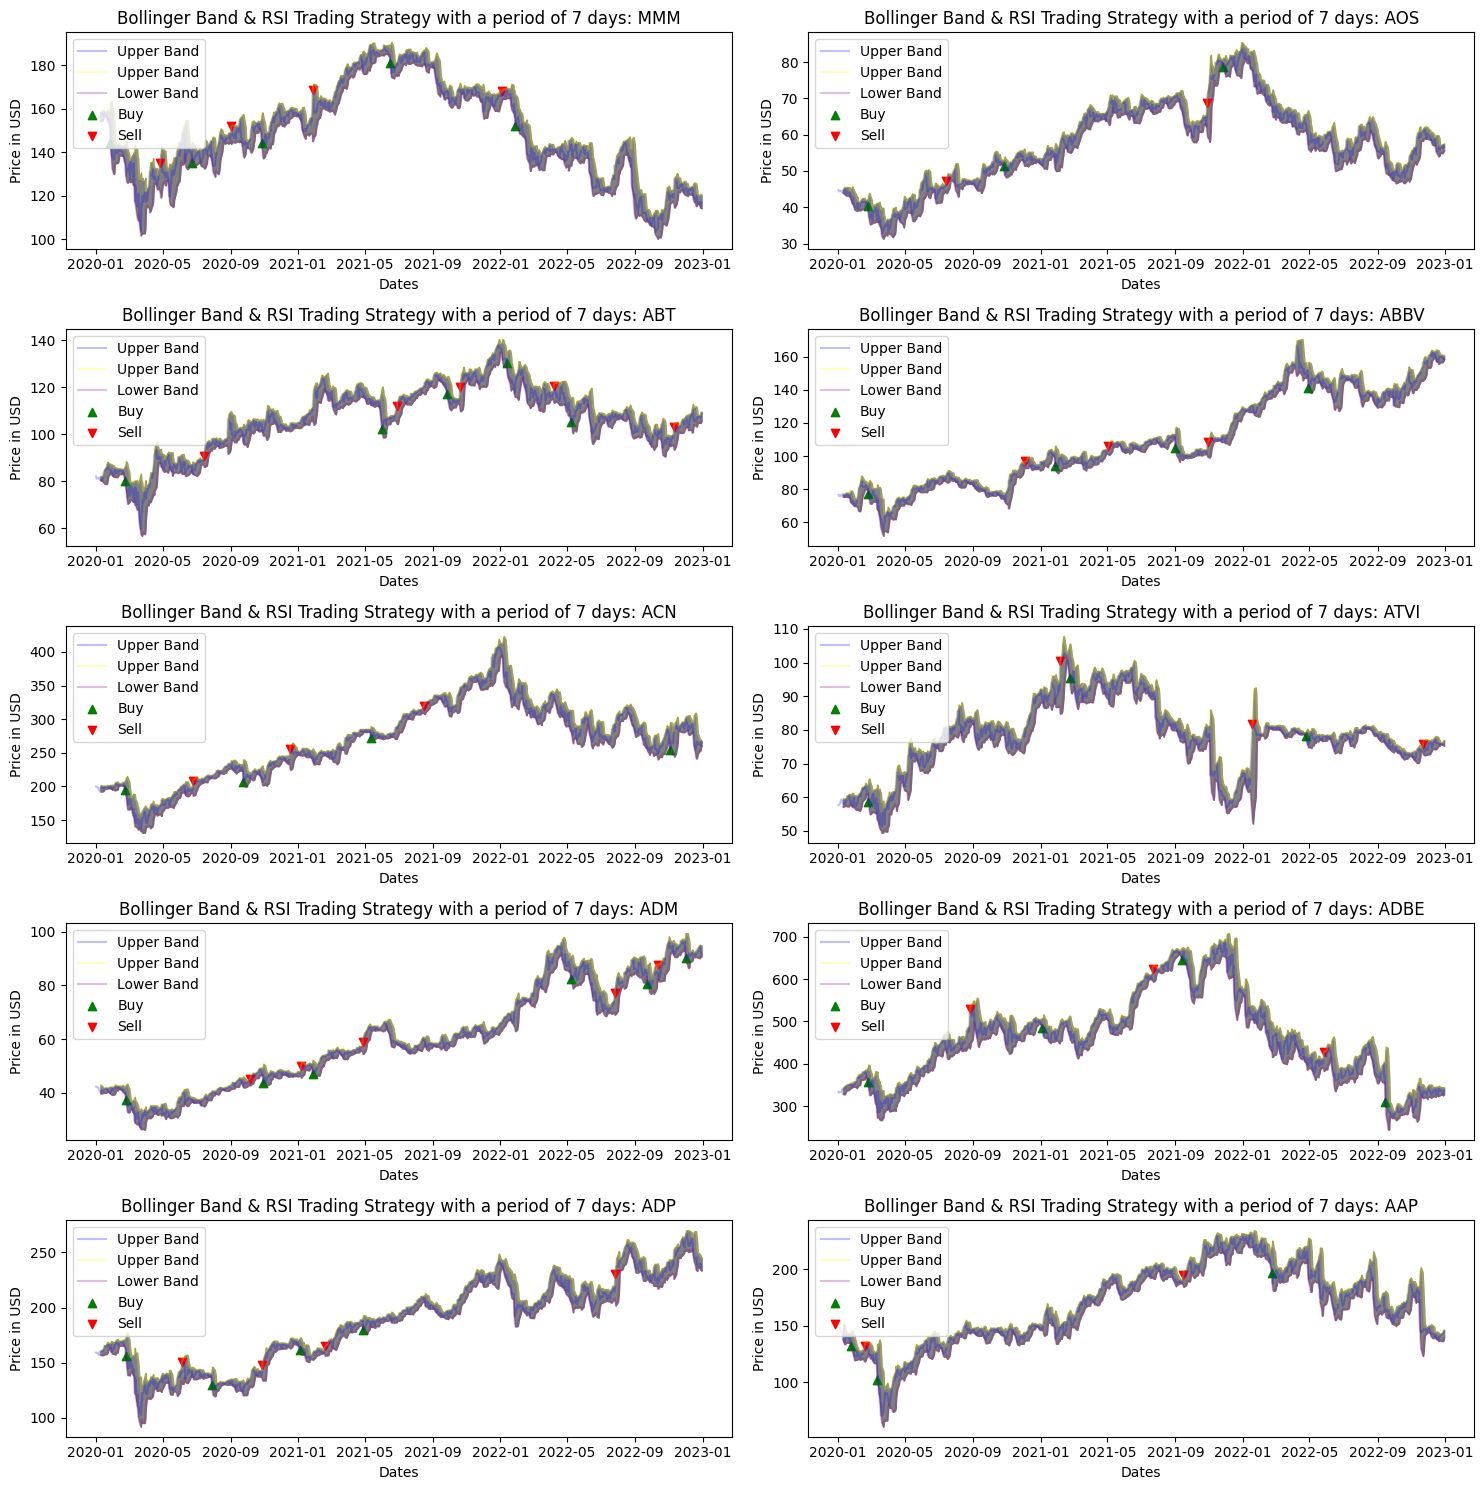

In [40]:
fig, axs = plt.subplots(5, 2, figsize=(15, 15))
# Plot each stock price and SMA
for sp500Df, (i, ax) in zip(updated_sp500Dfs[str(periods[0])], enumerate(axs.flat)):
    ax.plot(sp500Df['Adj Close'], label = 'Upper Band', alpha = 0.25, color='blue')
    ax.plot(sp500Df['UpperBand'], label = 'Upper Band', alpha = 0.25, color= 'yellow')
    ax.plot(sp500Df['LowerBand'], label = 'Lower Band', alpha = 0.25, color= 'purple')
    # ax.set_title('sin(x)')
    ax.fill_between(sp500Df.index, sp500Df['UpperBand'], sp500Df['LowerBand'], color='grey')
    ax.scatter(sp500Df.index, sp500Df['Buy'], label='Buy', alpha=1, marker= '^', color ='green')
    ax.scatter(sp500Df.index, sp500Df['Sell'], label='Sell', alpha=1, marker= 'v', color ='red')
    ax.set_title('Bollinger Band & RSI Trading Strategy with a period of '+str(periods[0])+' days: ' + sp500_filter_tickers[i])
    ax.set_ylabel('Price in USD')
    ax.set_xlabel('Dates')
    ax.legend(loc="upper left")

# Adjust the spacing between the subplots
fig.tight_layout()

# Display the figure
plt.show()

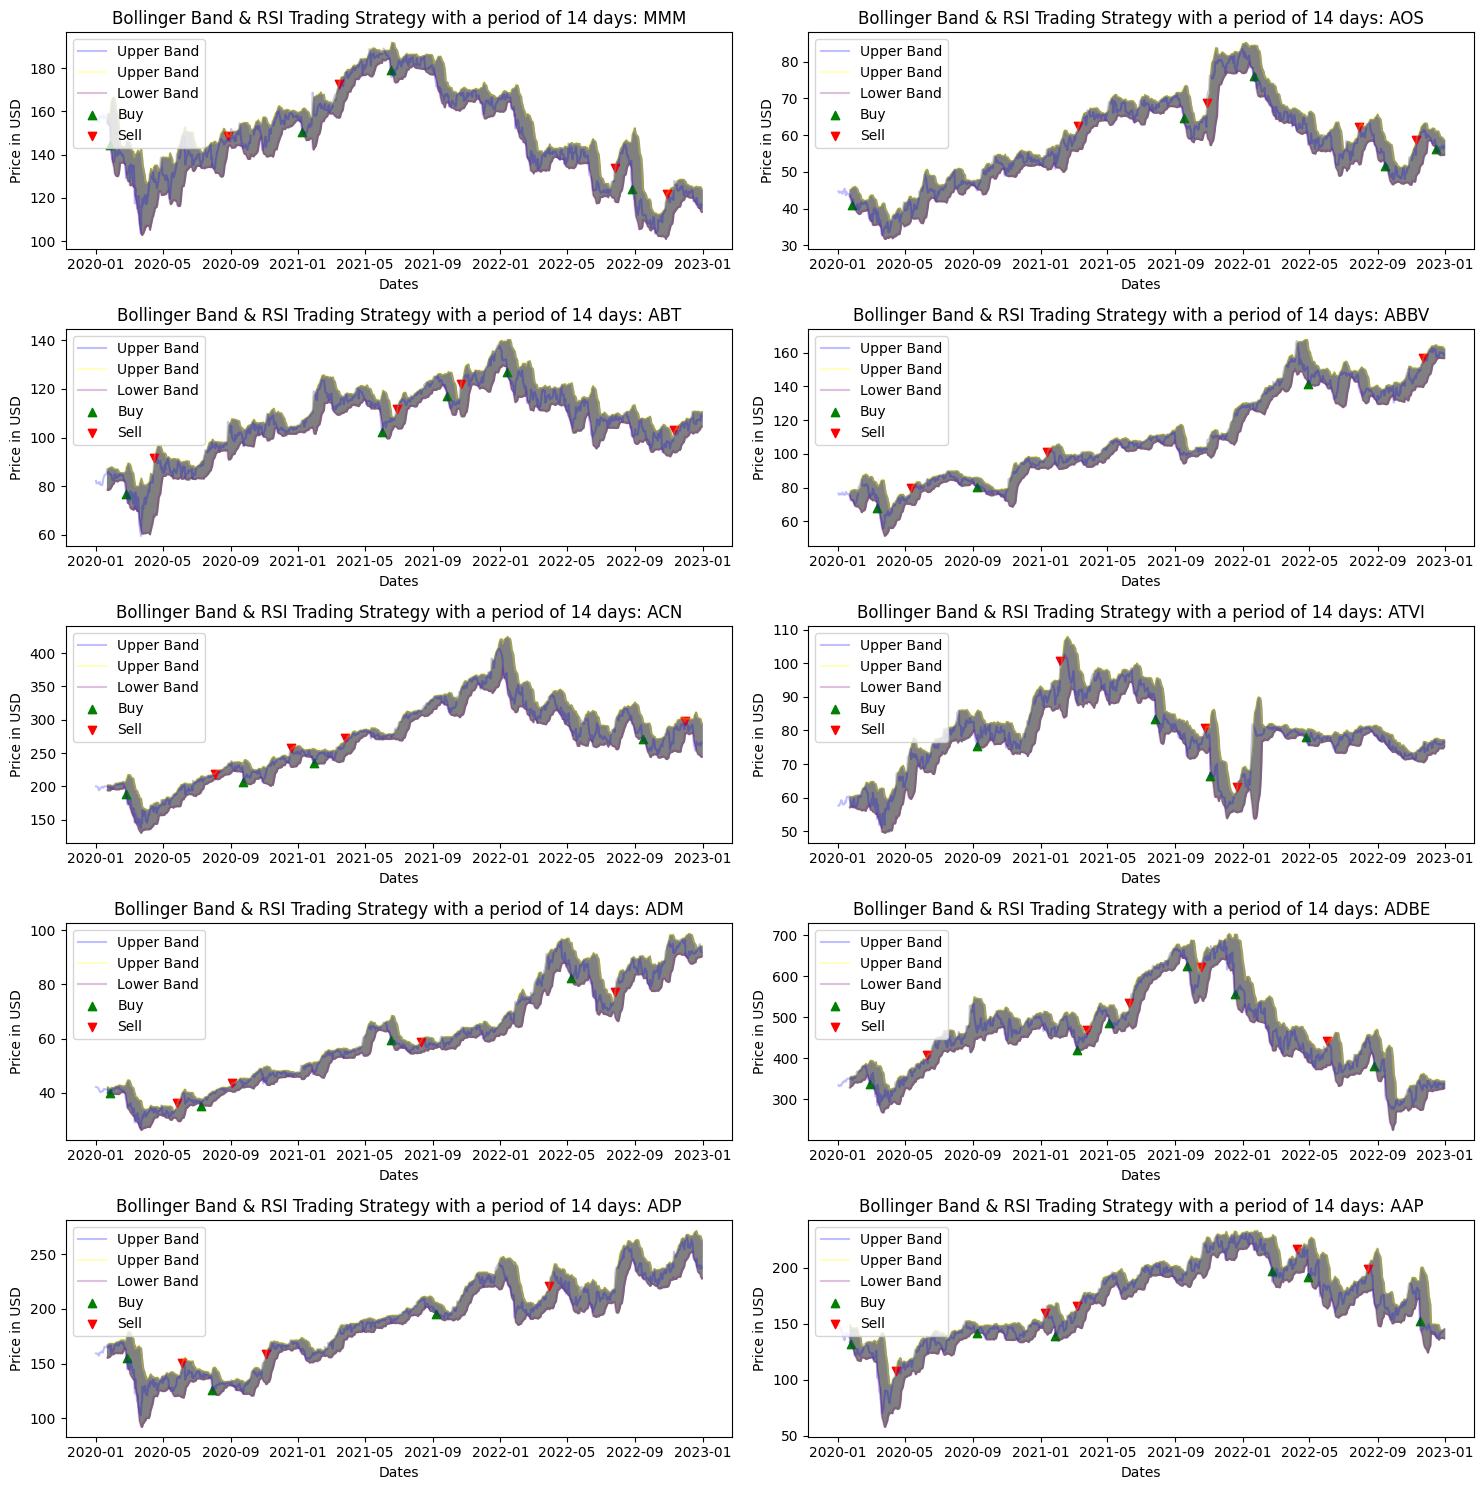

In [41]:
fig, axs = plt.subplots(5, 2, figsize=(15, 15))
# Plot each stock price and SMA
for sp500Df, (i, ax) in zip(updated_sp500Dfs[str(periods[1])], enumerate(axs.flat)):
    ax.plot(sp500Df['Adj Close'], label = 'Upper Band', alpha = 0.25, color='blue')
    ax.plot(sp500Df['UpperBand'], label = 'Upper Band', alpha = 0.25, color= 'yellow')
    ax.plot(sp500Df['LowerBand'], label = 'Lower Band', alpha = 0.25, color= 'purple')
    # ax.set_title('sin(x)')
    ax.fill_between(sp500Df.index, sp500Df['UpperBand'], sp500Df['LowerBand'], color='grey')
    ax.scatter(sp500Df.index, sp500Df['Buy'], label='Buy', alpha=1, marker= '^', color ='green')
    ax.scatter(sp500Df.index, sp500Df['Sell'], label='Sell', alpha=1, marker= 'v', color ='red')
    ax.set_title('Bollinger Band & RSI Trading Strategy with a period of '+str(periods[1])+' days: ' + sp500_filter_tickers[i])
    ax.set_ylabel('Price in USD')
    ax.set_xlabel('Dates')
    ax.legend(loc="upper left")

# Adjust the spacing between the subplots
fig.tight_layout()

# Display the figure
plt.show()

In [70]:
Culmutative_Simple_Return ={}
Culmutative_Log_Return = {}
Number_Trades = {}
Log_Sharpe_Ratio = {}
Log_Annualized_Sharpe_Ratio = {}
Simple_Sharpe_Ratio = {}
Simple_Annualized_Sharpe_Ratio = {}
Average_Culmutative_Simple_Return = 0
Average_Culmutative_Log_Return = 0

for sp500Df, ticker in zip(updated_sp500Dfs[str(periods[0])], sp500_filter_tickers):
    Culmutative_Simple_Return[ticker] = str(round(sp500Df['Culmutative_Simple_Return'][-1]*100, 2))+ "%"
    Average_Culmutative_Simple_Return += sp500Df['Culmutative_Simple_Return'][-1]*100
    Culmutative_Log_Return[ticker] = str(round(sp500Df['Culmutative_Log_Return'][-1]*100, 2))+ "%"
    Average_Culmutative_Log_Return += sp500Df['Culmutative_Log_Return'][-1]*100
    Number_Trades[ticker] = len(sp500Df[pd.isnull(sp500Df['Buy']) == False])
    Log_Sharpe_Ratio[ticker] = sp500Df['Strategy_Log_Returns'].mean()/sp500Df['Strategy_Log_Returns'].std()
    Log_Annualized_Sharpe_Ratio[ticker] = sp500Df['Strategy_Log_Returns'].mean()/sp500Df['Strategy_Log_Returns'].std() *(252**0.5)
    Simple_Sharpe_Ratio[ticker] = sp500Df['Strategy_Log_Returns'].mean()/sp500Df['Strategy_Log_Returns'].std()
    Simple_Annualized_Sharpe_Ratio[ticker] = sp500Df['Strategy_Log_Returns'].mean()/sp500Df['Strategy_Log_Returns'].std() *(252**0.5)
Average_Culmutative_Simple_Return = Average_Culmutative_Simple_Return/len(sp500_filter_tickers)
Average_Culmutative_Log_Return = Average_Culmutative_Log_Return/len(sp500_filter_tickers)


The average cumulative simple return of the strategy over a 7 day period:38.83%
The average cumulative log return of the strategy over a 7 day period.:22.64%


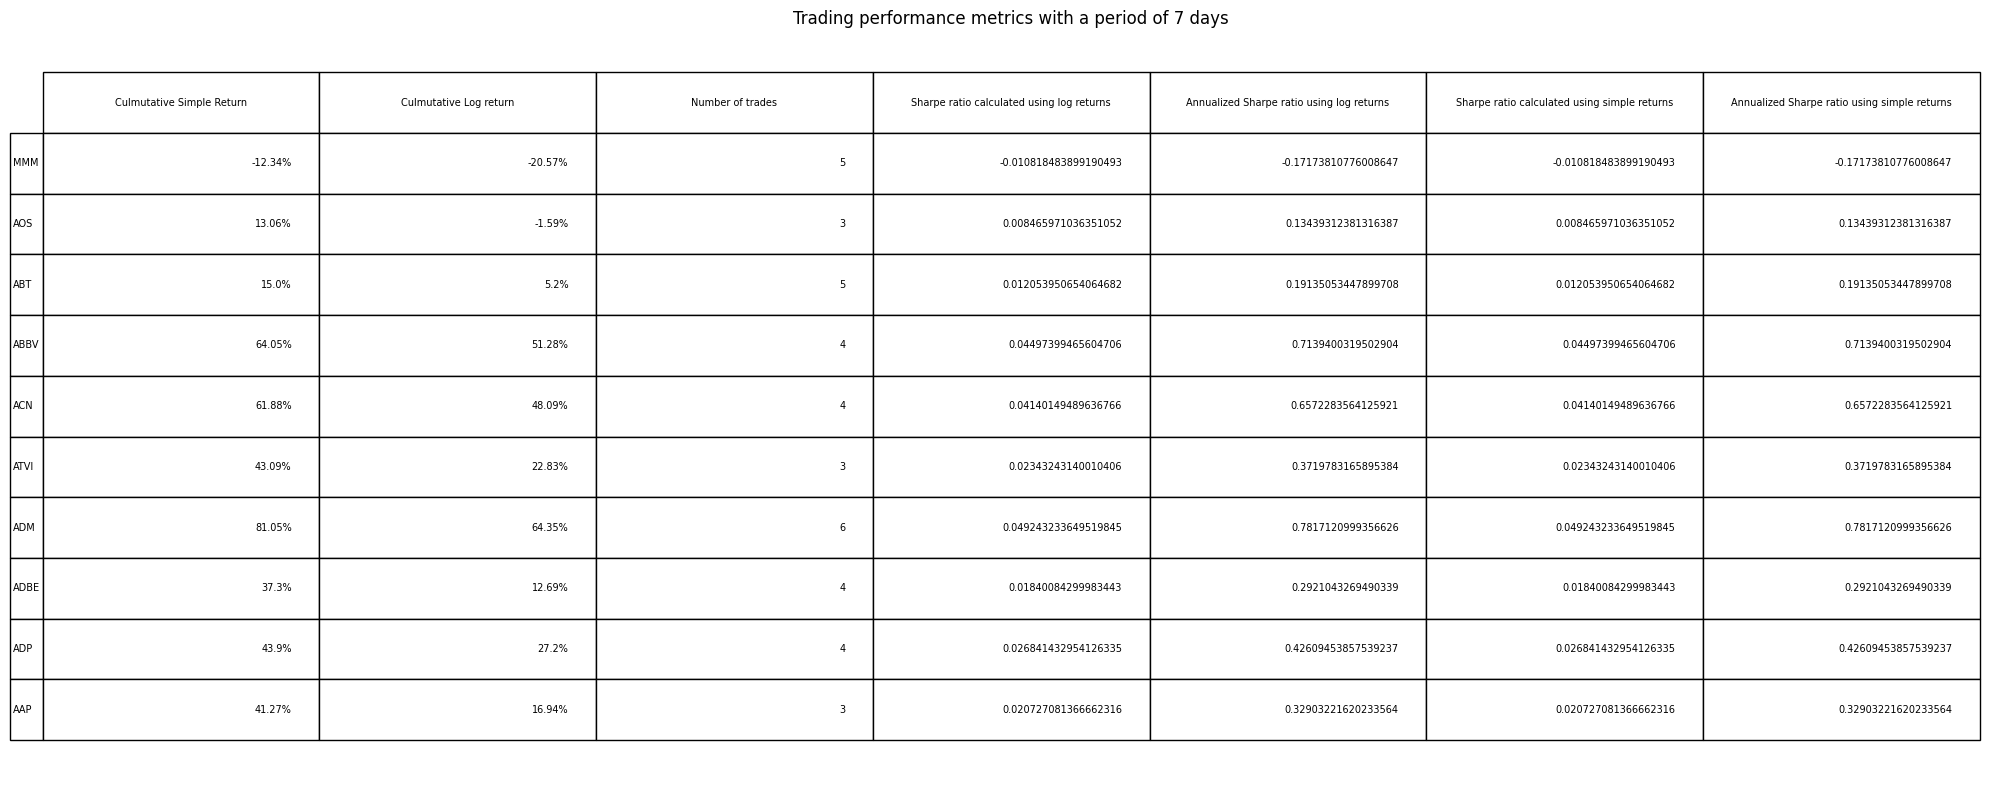

In [80]:
dataDf = pd.DataFrame({'Culmutative Simple Return':Culmutative_Simple_Return, 'Culmutative Log return': Culmutative_Log_Return, 
                       "Number of trades": Number_Trades, 'Sharpe ratio calculated using log returns': Log_Sharpe_Ratio, 
                       'Annualized Sharpe ratio using log returns': Log_Annualized_Sharpe_Ratio, 
                       'Sharpe ratio calculated using simple returns': Simple_Sharpe_Ratio, 
                       'Annualized Sharpe ratio using simple returns': Simple_Annualized_Sharpe_Ratio})
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
table = ax.table(cellText = dataDf.values,
          rowLabels = dataDf.index,
          colLabels = dataDf.columns,
          loc = "center"
         )
table.scale(1, 3)
table.auto_set_font_size(False)
table.set_fontsize(7)

ax.set_title("Trading performance metrics with a period of "+ str(periods[0])+" days")
ax.axis("off");
fig.tight_layout()
print("The average cumulative simple return of the strategy over a "+ str(periods[0]) +" day period:" + str(round(Average_Culmutative_Simple_Return, 2))+'%')
print("The average cumulative log return of the strategy over a " + str(periods[0]) +" day period.:" + str(round(Average_Culmutative_Log_Return, 2))+'%')


In [81]:
Culmutative_Simple_Return ={}
Culmutative_Log_Return = {}
Number_Trades = {}
Log_Sharpe_Ratio = {}
Log_Annualized_Sharpe_Ratio = {}
Simple_Sharpe_Ratio = {}
Simple_Annualized_Sharpe_Ratio = {}
Average_Culmutative_Simple_Return = 0
Average_Culmutative_Log_Return = 0
for sp500Df, ticker in zip(updated_sp500Dfs[str(periods[1])], sp500_filter_tickers):
    Culmutative_Simple_Return[ticker] = str(round(sp500Df['Culmutative_Simple_Return'][-1]*100, 2))+ "%"
    Average_Culmutative_Simple_Return += sp500Df['Culmutative_Simple_Return'][-1]*100
    Culmutative_Log_Return[ticker] = str(round(sp500Df['Culmutative_Log_Return'][-1]*100, 2))+ "%"
    Average_Culmutative_Log_Return += sp500Df['Culmutative_Log_Return'][-1]*100
    Number_Trades[ticker] = len(sp500Df[pd.isnull(sp500Df['Buy']) == False])
    Log_Sharpe_Ratio[ticker] = sp500Df['Strategy_Log_Returns'].mean()/sp500Df['Strategy_Log_Returns'].std()
    Log_Annualized_Sharpe_Ratio[ticker] = sp500Df['Strategy_Log_Returns'].mean()/sp500Df['Strategy_Log_Returns'].std() *(252**0.5)
    Simple_Sharpe_Ratio[ticker] = sp500Df['Strategy_Log_Returns'].mean()/sp500Df['Strategy_Log_Returns'].std()
    Simple_Annualized_Sharpe_Ratio[ticker] = sp500Df['Strategy_Log_Returns'].mean()/sp500Df['Strategy_Log_Returns'].std() *(252**0.5)

Average_Culmutative_Simple_Return = Average_Culmutative_Simple_Return/len(sp500_filter_tickers)
Average_Culmutative_Log_Return = Average_Culmutative_Log_Return/len(sp500_filter_tickers)

The average cumulative simple return of the strategy over a 14 day period:28.39%
The average cumulative log return of the strategy over a 14 day period.:16.59%


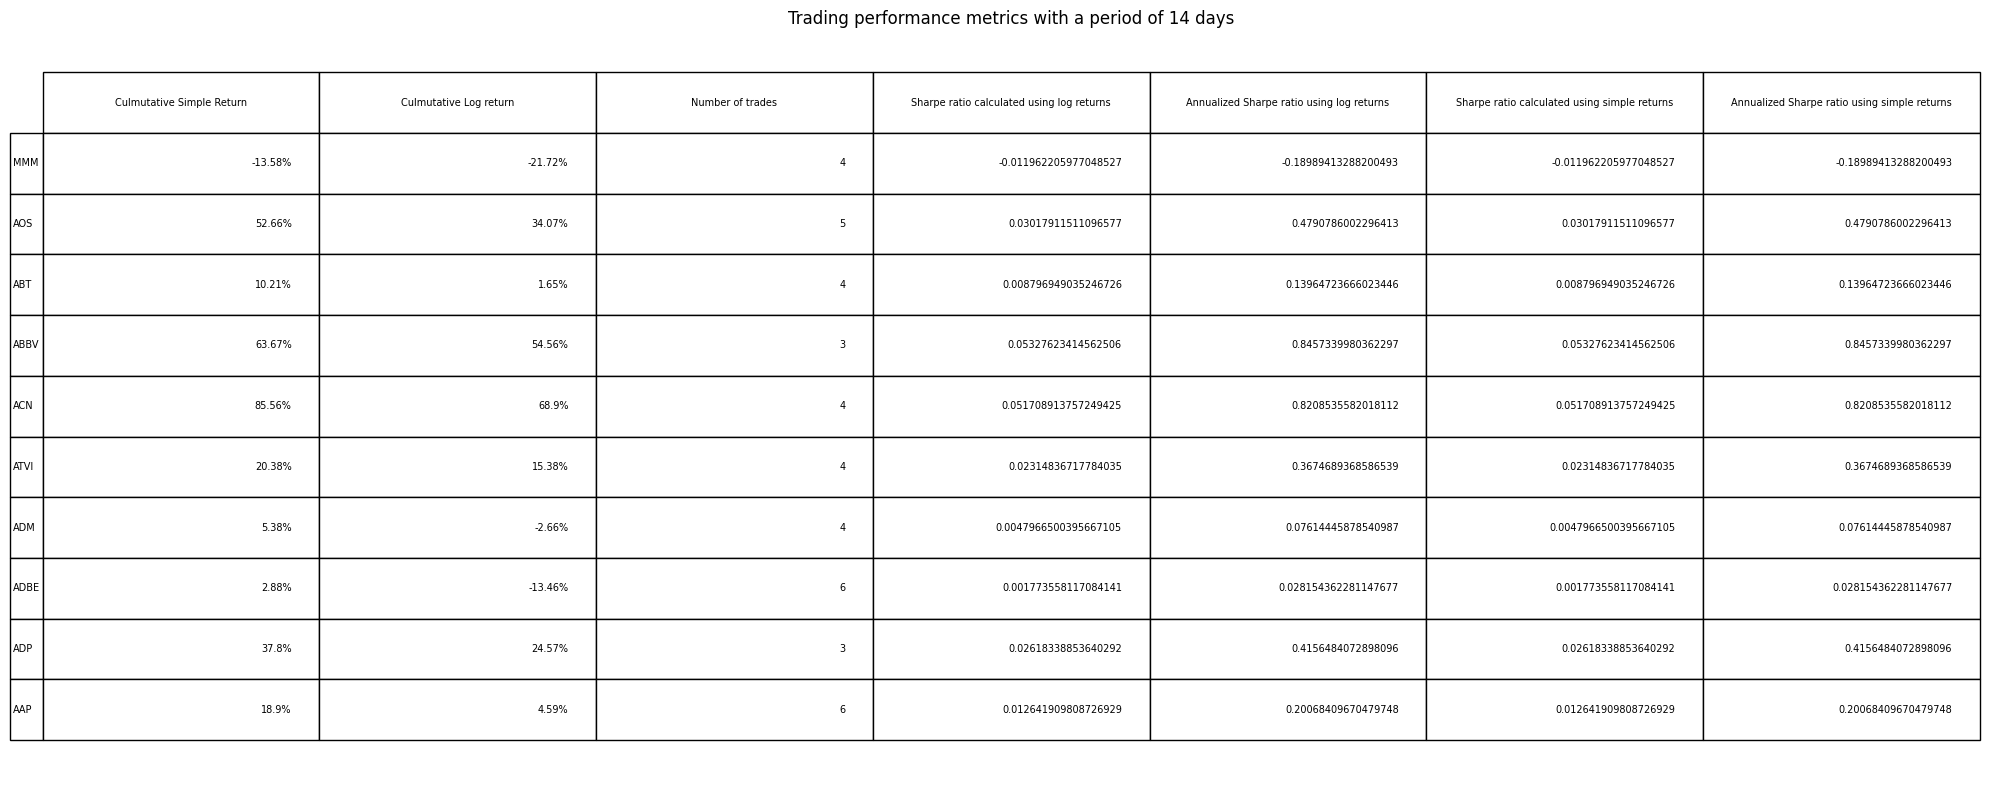

In [83]:
dataDf = pd.DataFrame({'Culmutative Simple Return':Culmutative_Simple_Return, 'Culmutative Log return': Culmutative_Log_Return, 
                       "Number of trades": Number_Trades, 'Sharpe ratio calculated using log returns': Log_Sharpe_Ratio, 
                       'Annualized Sharpe ratio using log returns': Log_Annualized_Sharpe_Ratio, 
                       'Sharpe ratio calculated using simple returns': Simple_Sharpe_Ratio, 
                       'Annualized Sharpe ratio using simple returns': Simple_Annualized_Sharpe_Ratio})
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
table = ax.table(cellText = dataDf.values,
          rowLabels = dataDf.index,
          colLabels = dataDf.columns,
          loc = "center"
         )
table.scale(1, 3)
table.auto_set_font_size(False)
table.set_fontsize(7)

ax.set_title("Trading performance metrics with a period of "+str(periods[1])+" days")
ax.axis("off");
fig.tight_layout()

print("The average cumulative simple return of the strategy over a "+ str(periods[1]) +" day period:" + str(round(Average_Culmutative_Simple_Return, 2))+'%')
print("The average cumulative log return of the strategy over a " + str(periods[1]) +" day period.:" + str(round(Average_Culmutative_Log_Return, 2))+'%')

